# Overview [22/01/2023]

1. Detele duplicates
2. Delete users with less than 10 interactions

## Delete users with less than 10 interactions

### Evaristo


### Antonio

In [ ]:
# He puesto todo el flujo aqui 
# Simplemente ejecutar celda inferior con definicion de funnciones 
# Luego ejecutar la celda siguiente para ver la llamada

In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import datetime
import plotly.express as px
import plotly.graph_objects as go

#definicion de funciones y datos auxiliares

# Url de dataset que queremos descargar
urls=[
    "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/CDs_and_Vinyl_5.json.gz",
    "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz",
    "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments_5.json.gz" 
]

# Nombre de los archivos
files=[
    "CDs_and_Vinyl_5.json.gz",
    "Digital_Music_5.json.gz",
    "Musical_Instruments_5.json.gz"
]

# Columnas relevantes para el analisis
columnas_interesantes=['overall', 'reviewTime', 'reviewerID',
                       'asin', 'reviewerName', 'unixReviewTime']

# Minimo de reviews por usuario
min_reviews=10


def helper(arg):
   if(os.system(arg) == 0):
        print(arg," completed")
        return None


def get_dataset_basic_info(df, nombre):
  numero_clientes=len(df.reviewerID.unique())
  numero_productos=len(df.asin.unique())

  return(print("#"*25,"\n",nombre,"\n","#"*25,"\n"*2, "Numero total de clientes: ", numero_clientes,"\n",
      "Numero total de productos: ", numero_productos, "\n",
      "Numero total de reviews: ", df.shape[0]))


def load_data_raw():

  '''
  Funcion que descarga los datasets descomentados. 
  Al tener la misma estructura los dataset son concatenados en un unico df final
  '''

  ### Descarga de información
  for url in urls:
    helper("wget "+url+ " --no-check-certificate")

  concat_df=[]

  for archivo in files:
    df = []
    with gzip.open(archivo) as f:
        for l in f:
            df.append(json.loads(l.strip()))
      
    # tamaño del dataset
    print("El dataset: ",archivo[:-2] ," tiene: ",len(df), "registros")

    # Cnversion a tabla 
    df = pd.DataFrame.from_dict(df)

    concat_df.append(df)

  df_concatenado=pd.concat(concat_df)

  return df_concatenado

def treat_dataset_src(df, min_reviews, columnas_interesantes):

    '''
    Funcion que trata el dataset original
    Realiza conversiones de tipo
    Filtra en funcion de unas columnas seleccionadas
    Filtra solo usuarios con mas de X reviews
    Elimina los usuarios que han puesto > 1 review el mismo dia sobre el mismo producto
    '''

    df=df.loc[:, columnas_interesantes]

    # Conversion de tipo
    df["reviewTime"]=pd.to_datetime(df["reviewTime"])
    df['overall'] = pd.to_numeric(df['overall'].replace(',','', regex=True))
    df["unixReviewTime"]=df["unixReviewTime"].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    df['Year']= pd.to_datetime(df['reviewTime']).dt.year

    # Seleccionamos los ids que tienen mas de X reviews 
    aux=pd.DataFrame(df.groupby(["reviewerID"]).count()["overall"])
    aux=aux[aux["overall"]>=min_reviews].reset_index()
    clientes=aux["reviewerID"]

    df1=df[df['reviewerID'].isin(clientes)]

    # Eliminamos los ids que tienen duplicaods
    duplicados=pd.DataFrame(df1.groupby(["reviewerID", "asin", "unixReviewTime"]).count()["overall"])
    reviews_duplicadas=duplicados[duplicados["overall"]>1].reset_index()
    ids_duplicados=reviews_duplicadas["reviewerID"]

    df2=df1[~df1.reviewerID.isin(ids_duplicados)]

    return df2


def barplot_reviews(df):

  '''
  Visualizaciones interesantes:
  Barplot con el numero de usuarios en funcion del numero de reviews en dataset
  '''

  # Definicion de dataset
  data = pd.DataFrame(df.groupby(["reviewerID"]).count()).reset_index().groupby(["overall"]).count().reset_index()

  # Definicion del objeto fig
  fig = go.Figure()

  # Gráfica
  fig.add_trace(go.Bar(x=data["overall"],
                  y=data["reviewerID"],
                  name='Rest of world',
                  marker_color='rgb(55, 83, 109)'
                  ))


  fig.update_layout(
      title='¿Cuantos usuarios tienen x reviews?',
      xaxis_tickfont_size=14,
      yaxis=dict(
          title='# de usuarios',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='# de reviews',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return(fig.show())

def timeline_reviews(df):

  # Definicion de dataset
  data = pd.DataFrame(df.groupby(["Year"]).count()).reset_index()

  # Definicion de objeto figura
  fig = go.Figure()

  # Definicion de grafica
  fig.add_trace(go.Bar(x=data["Year"],
                  y=data["overall"],
                  name='Rest of world',
                  marker_color='rgb(55, 83, 109)'
                  ))


  fig.update_layout(
      title='¿Cuantas reviews tenemos por año?',
      xaxis_tickfont_size=14,
      yaxis=dict(
          title='# de usuarios',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='Año',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return(fig.show())


In [ ]:
# descarga de datasets seleccionados
df = load_data_raw()
print("\n")

# Informacion del dataset RAW
get_dataset_basic_info(df, "dataset original (RAW)")
print("\n")

# Tratamiento de datos
df2 = treat_dataset_src(df, min_reviews, columnas_interesantes)
print("\n")

# Informacion del dataset SRC
get_dataset_basic_info(df2, "dataset tratado (SRC)")
print("\n")

# Informacion visual del dataset
barplot_reviews(df2)
timeline_reviews(df2)

wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/CDs_and_Vinyl_5.json.gz --no-check-certificate  completed
wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz --no-check-certificate  completed
wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments_5.json.gz --no-check-certificate  completed
El dataset:  CDs_and_Vinyl_5.json.  tiene:  1443755 registros
El dataset:  Digital_Music_5.json.  tiene:  169781 registros
El dataset:  Musical_Instruments_5.json.  tiene:  231392 registros


######################### 
 dataset original (RAW) 
 ######################### 

 Numero total de clientes:  149616 
 Numero total de productos:  96130 
 Numero total de reviews:  1844928




######################### 
 dataset tratado (SRC) 
 ######################### 

 Numero total de clientes:  30954 
 Numero total de productos:  87154 
 Numero total de reviews:  571493




### Joan

--2023-01-27 21:08:05--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments.csv
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 63130088 (60M) [text/csv]
Saving to: ‘Musical_Instruments.csv’

Musical_Instruments 100%[===================>]  60.21M  44.6MB/s    in 1.3s    

2023-01-27 21:08:07 (44.6 MB/s) - ‘Musical_Instruments.csv’ saved [63130088/63130088]


null analysis ratings
item         0
user         0
rating       0
timestamp    0
dtype: int64

number of user ratings (rows): 1512530
number of users: 903330
number of items: 112222

users with less than 10 ratings: 794130

after reduction:
number of user ratings: 587286
number of users: 109200
number of items: 75747


KeyboardInterrupt: ignored

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f522009c9d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/transforms.py", line 178, in <lambda>
    target=child._parents: target.pop(sid))
KeyboardInterrupt: 


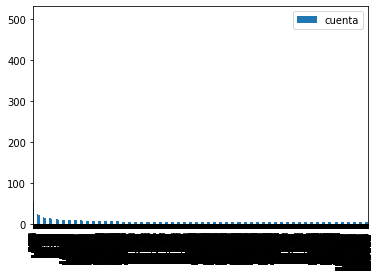

In [ ]:
# Yo he trabajado con el fichero de ratings, el csv
# indico el proceso para eliminar usuarios con menos de 10 ratings

import torch
import pandas as pd
import gzip
import numpy as np
import json
import csv
import os
import scipy.sparse as sp
import plotly.express as px
import matplotlib.pyplot as plt
import datetime

# cargar dataset
!wget "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments.csv" --no-check-certificate 


cols = ['item', 'user', 'rating', 'timestamp']
df_ratings = pd.read_csv('Musical_Instruments.csv', delimiter=",", names=cols)

# basic analysis
print("\nnull analysis ratings")
print(df_ratings.isnull().sum().sort_values(ascending=False))
print('\nnumber of user ratings (rows): ' + str(df_ratings.user.count()))
print('number of users: ' + str(len(df_ratings.user.unique())))
print('number of items: ' + str(len(df_ratings.item.unique())))

# usuarios con menos de 10 ratings
df_ratings_item_user = df_ratings.groupby(['user'])['rating'].agg(cuenta='count').sort_values(['cuenta'], ascending=[False]).reset_index()
df_user_less_than_10_ratings = df_ratings_item_user.query('cuenta<3')
print("\nusers with less than 10 ratings: " + str(df_user_less_than_10_ratings.user.count()))

# borrar usuarios seleccionados
df_ratings = df_ratings[~df_ratings.user.isin(df_user_less_than_10_ratings.user)]

# new dataset size
print("\nafter reduction:")
print('number of user ratings: ' + str(df_ratings.user.count()))
print('number of users: ' + str(len(df_ratings.user.unique())))
print('number of items: ' + str(len(df_ratings.item.unique())))

# plot
df_ratings_user_ratings = df_ratings.groupby(['user'])['rating'].agg(cuenta='count').sort_values(['cuenta'], ascending=[False]).reset_index()
ax = df_ratings_user_ratings.plot.bar(x='user', y='cuenta')
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
plt.legend(["rating per user"])
plt.title('users with more than 10 or more ratings')
plt.xlabel("ratings")
plt.show()


### Brenda

In [ ]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=f70dbb5da590d291dde251ebeda697e5745c0ab6a748f06efe1a6f5b974cac5b
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [ ]:
# import 
import os
import wget
from zipfile import ZipFile
import pandas as pd
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import gzip
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
def get_dataframe_from_json(filename, url, csv_filename):
    if not os.path.exists(csv_filename):
        filename = wget.download(url) if not os.path.exists(filename) else filename
        data = []
        with gzip.open(filename,'rb') as f:
            for line in f.readlines():
                data.append(json.loads(line))
        df = pd.DataFrame.from_records(data)
        df = df.rename(columns={'asin': 'itemID'})
        df["itemID"] = pd.Categorical(df["itemID"]).codes
        df["reviewerID"] = pd.Categorical(df["reviewerID"]).codes # not meta
        #df.to_csv(csv_filename, index=False)
        os.remove(filename)
    else:
        df = pd.read_csv(csv_filename)
    return df
    
def get_dataframe_from_csv(url, csv_filename):
    if not os.path.exists(csv_filename):
        filename = wget.download(url)
        cols = ['itemID', 'reviewerID', 'rating', 'timestamp']
        df = pd.read_csv(filename)
        df.columns = cols
        df["itemID"] = pd.Categorical(df["itemID"]).codes
        df["reviewerID"] = pd.Categorical(df["reviewerID"]).codes # not meta
        df.to_csv(csv_filename, index=False)
        os.remove(filename)
    else:
        df = pd.read_csv(csv_filename)
    return df

def print_info(df):
    print('\nnumber of reviews: {}'.format(df.shape[0]))
    print('number of users/clients: {}'.format(len(df.reviewerID.unique())))
    print('number of items/products: {}'.format(len(df.itemID.unique())))

# # Musical_Instruments_5.json.gz	    2022-10-18 13:19	38M	 
# url_json = "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments_5.json.gz"
# filename = "Musical_Instruments_0.gz"
# csv_filename = 'Musical_Instruments_from_json.csv'
# df_json = get_dataframe_from_json(filename, url_json, csv_filename)
# print_info(df_json)

# Musical_Instruments.csv	        2022-10-18 13:17	60M	 
url_csv = "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments.csv"
csv_filename = "Musical_Instruments_1.csv"
df_msc_instr = get_dataframe_from_csv(url_csv, csv_filename)
print_info(df_msc_instr)



number of reviews: 1512529
number of users/clients: 903329
number of items/products: 112222


In [ ]:
th = 3

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

histogram_reviewerID = df_msc_instr.groupby(by="reviewerID")["itemID"].agg(['count'])
reviewerID_above_th = histogram_reviewerID.query("count < {th}".format(th=th)).index.values.tolist()
new_df_msc_instr = filter_rows_by_values(df_msc_instr, "reviewerID", reviewerID_above_th)

print("Dataset of users with less than {} ratings:".format(th))
print('\tnumber of reviews: {}'.format(df_msc_instr.shape[0] - new_df_msc_instr.shape[0]))
print('\tnumber of users: {}'.format(len(df_msc_instr.reviewerID.unique()) - len(new_df_msc_instr.reviewerID.unique())))
print('\tnumber of items: {}'.format(len(df_msc_instr.itemID.unique()) - len(new_df_msc_instr.itemID.unique())))

print("\nDataset of users with more (or equal) than {} ratings:".format(th))
print('\tnumber of reviews: {}'.format(new_df_msc_instr.shape[0]))
print('\tnumber of users: {}'.format(len(new_df_msc_instr.reviewerID.unique())))
print('\tnumber of items: {}'.format(len(new_df_msc_instr.itemID.unique())))

Dataset of users with less than 3 ratings:
	number of reviews: 925243
	number of users: 794129
	number of items: 36475

Dataset of users with more (or equal) than 3 ratings:
	number of reviews: 587286
	number of users: 109200
	number of items: 75747


## Delete duplicates

### Evaristo


### Antonio

### Joan

number of user ratings: 168983
number of user ratings duplicated: 5363
number of user ratings after drop duplicated: 163620
number of users with multiple ratings of the same item: 1392
sum of the multiple ratings, second and next may be dropped:2921
number of multiple ratings that may be dropped:1529



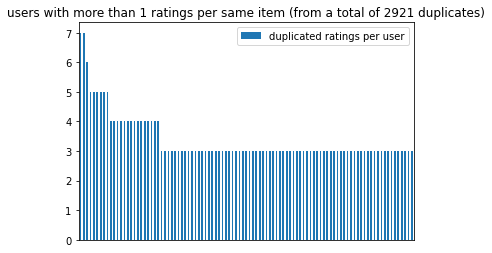


number of remaining user item ratings after drop multiple ratings:162091

validation:
number of users with multiple ratings of the same item: 0

final dataset proposal:
number of user ratings (rows): 162091
number of users: 10073
number of items: 41140


In [ ]:
# partimos de df_ratings con usuarios de menos de 10 ratings eliminados
print('number of user ratings: ' + str(df_ratings.user.count()))

# eliminar duplicados con el mismo rating
# calcular cuantos hay
df_dupl=df_ratings[df_ratings.duplicated()]
print('number of user ratings duplicated: ' + str(df_dupl.user.count()))
# eliminar
df_ratings.sort_values(['item', 'user', 'timestamp', 'rating'], ascending=[False, False, False, False])
df_ratings = df_ratings.drop_duplicates(keep='last')
print('number of user ratings after drop duplicated: ' + str(df_ratings.user.count()))

# eliminacion de ratings múltiples de un usuario sobre el mismo item
df_ratings_item_user = df_ratings.groupby(['user','item'])['rating'].agg(cuenta='count').sort_values(['cuenta'], ascending=[False]).reset_index()
df_ratings_item_user = df_ratings_item_user.query('cuenta > 1')
print('number of users with multiple ratings of the same item: ' + str(df_ratings_item_user.user.count()))

items_rating_duplicado = df_ratings_item_user.cuenta.sum()
print("sum of the multiple ratings, second and next may be dropped:"+ str(items_rating_duplicado))
print("number of multiple ratings that may be dropped:"+ str(items_rating_duplicado-df_ratings_item_user.user.count())+"\n")

# plot
if items_rating_duplicado > 0:
    df_ratings_item_user = df_ratings_item_user.query('cuenta > 2')
    ax = df_ratings_item_user.plot.bar(x='user', y='cuenta')
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)
    plt.legend(["duplicated ratings per user"])
    plt.title('users with more than 1 ratings per same item (from a total of '+str(items_rating_duplicado)+' duplicates)')
    plt.xlabel("users")
    plt.show()

# eliminar ratings múltiples y nos quedamos el ultimo
df_ratings = df_ratings.sort_values(['user', 'item', 'timestamp', 'rating'], ascending=[True, True, True, True])
df_ratings = df_ratings.drop_duplicates(subset=['item', 'user'], keep='last')
print("\nnumber of remaining user item ratings after drop multiple ratings:"+ str(df_ratings.user.count()))

# comprobacion
df_ratings_item_user = df_ratings.groupby(['item','user'])['rating'].agg(cuenta='count').sort_values(['cuenta'], ascending=[False]).reset_index()
df_ratings_item_user = df_ratings_item_user.query('cuenta > 1')
print("\nvalidation:")
print('number of users with multiple ratings of the same item: ' + str(df_ratings_item_user.user.count()))

# final dataset proposal
print("\nfinal dataset proposal:")
print('number of user ratings (rows): ' + str(df_ratings.user.count()))
print('number of users: ' + str(len(df_ratings.user.unique())))
print('number of items: ' + str(len(df_ratings.item.unique())))



### Brenda

In [ ]:
def delete_rows_from_df(df, list_rows):
    return df.drop(list_rows)

df = new_df_msc_instr[["reviewerID","itemID", "timestamp"]].sort_values(by=["timestamp"], ascending=False)
df_not_duplicated = delete_rows_from_df(df, df[df.duplicated()].reviewerID.index.values.tolist())

# Para seguir mismo formato que Joan
print('* number of users duplicated: {}'.format(df[df.duplicated()].reviewerID.count()))

print("\nDataset of users with more (or equal) than {} ratings:".format(th))
print('\tnumber of reviews: {}'.format(new_df_msc_instr.shape[0]))
print('\tnumber of users: {}'.format(len(new_df_msc_instr.reviewerID.unique())))
print('\tnumber of items: {}'.format(len(new_df_msc_instr.itemID.unique())))

print("\nAFTER DATAFRAME WITH USERS WHICH RATINGS ARE {} OR MORE".format(th))
print('* number of reviews: {}'.format(df_not_duplicated.shape[0]))
print('* number of users: {}'.format(len(df_not_duplicated.reviewerID.unique())))
print('* number of items: {}'.format(len(df_not_duplicated.itemID.unique())))

* number of users duplicated: 22125

Dataset of users with more (or equal) than 3 ratings:
	number of reviews: 587286
	number of users: 109200
	number of items: 75747

AFTER DATAFRAME WITH USERS WHICH RATINGS ARE 3 OR MORE
* number of reviews: 565161
* number of users: 109200
* number of items: 75747


In [ ]:
# CODIGO UNIFICADO

In [ ]:
#================================================================#
#============= Proceso de extraccion y tratamiento ==============#
#================================================================#

#====================== Import de librerias =====================#

import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import datetime
import plotly.express as px
import plotly.graph_objects as go


#============ Definicion de valores de configuracion ============#

# Url de dataset que queremos descargar
urls=[
  "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments.csv"
]

# Nombre de los archivos
files=[
  "Musical_Instruments.csv"
]

# Minimo de reviews por usuario
min_reviews=3
min_usuarios=3

# Nombre de columnas
col_names = {"col_id_product": "asin",
             "col_id_reviewer": "reviewerID",
             "col_unix_time": "timestamp",
             "col_year": "year",
             "col_rating": "overall"}

#============ Definicion de funciones de extraccion y tratamiento ============#

def helper(arg):

   '''
   Funcion auxiliar para dar informacion del proceso de descarga
   '''

   if(os.system(arg) == 0):
        print(arg," completed")
        return None

def get_dataset_basic_info(df, nombre):

  '''
  Funcion que retorna infomracion de # de clientes, productos y reviews en dataset elegido
  '''

  aux=len(nombre)
  numero_clientes=len(df[col_names["col_id_reviewer"]].unique())
  numero_productos=len(df[col_names["col_id_product"]].unique())

  return(print("\n","#"*aux,"\n",nombre.center(aux),"\n","#"*aux,"\n"*2, "Numero total de clientes: ", numero_clientes,"\n",
      "Numero total de productos: ", numero_productos, "\n",
      "Numero total de reviews: ", df.shape[0],"\n"))


def load_data_raw():

  '''
  Funcion que descarga los datasets de las url elegidas. 
  '''

  cols = [col_names["col_id_product"], col_names["col_id_reviewer"], col_names["col_rating"], col_names["col_unix_time"]]

  ### Descarga de información
  for url in urls:
    helper("wget " +url+ " --no-check-certificate")

  for archivo in files:
    df = pd.read_csv(archivo, delimiter=",", names=cols)

  return df


def treat_dataset_src(df, min_reviews,info=False):

    '''
    Funcion que trata el dataset original
    Realiza conversiones de tipo
    Filtra duplicados (usuarios que han puesto mas de una review sobre un producto el mismo día)
    Filtra productos comprados por al menos 3 usuarios
    Filtra solo usuarios con mas de X reviews
    '''

    # Conversion de tipo
    df[col_names["col_rating"]] = pd.to_numeric(df[col_names["col_rating"]].replace(',','', regex=True))
    df[col_names["col_unix_time"]]=df[col_names["col_unix_time"]].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    df[col_names["col_year"]]= pd.to_datetime(df[col_names["col_unix_time"]]).dt.year

    # Duplicados
    df_duplicates = df[[col_names["col_id_reviewer"],col_names["col_id_product"], col_names["col_unix_time"]]].sort_values(by=[col_names["col_unix_time"]], ascending=False)
    df = df.drop(df_duplicates[df_duplicates[[col_names["col_id_reviewer"],col_names["col_id_product"]]].duplicated()][col_names["col_id_reviewer"]].index.values.tolist())
   
    if (info==True):
      get_dataset_basic_info(df,"Informacion tras eliminar duplicados")

    productos_a_eliminar=[1]
    clientes_a_eliminar=[1]
    iteracion = 1
    while (len(productos_a_eliminar)!=0)and(len(clientes_a_eliminar)!=0):

      # Minimo de usuarios que han comprado el producto productos 
      aux=df.groupby([col_names["col_id_product"]])[col_names["col_id_reviewer"]].count().reset_index()
      aux2=aux[aux[col_names["col_id_reviewer"]]<min_usuarios].reset_index() # usuarios a eliminar
      aux=aux[aux[col_names["col_id_reviewer"]]>=min_usuarios].reset_index() # usuarios a conservar
      productos=aux[col_names["col_id_product"]]
      df=df[df[col_names["col_id_product"]].isin(productos)]

      productos_a_eliminar=aux2[col_names["col_id_product"]]


      if (info==True):
        get_dataset_basic_info(df,f"Iteracion: {iteracion}. Informacion tras eliminar productos comprados por menos de {min_usuarios} personas")

      # Seleccionamos los ids de producto que tienen mas de X reviews 
      aux=df.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].count().reset_index()
      aux2=aux[aux[col_names["col_rating"]]<min_reviews].reset_index()
      aux=aux[aux[col_names["col_rating"]]>=min_reviews].reset_index()
      clientes=aux[col_names["col_id_reviewer"]]
      df=df[df[col_names["col_id_reviewer"]].isin(clientes)]

      clientes_a_eliminar=aux2[col_names["col_id_reviewer"]]

      if (info==True):
        get_dataset_basic_info(df,f"Iteracion: {iteracion}. Informacion tras eliminar usuarios con menos de {min_reviews} reviews")

      iteracion+=1

    return df


#============ Visualización ============#

def barplot_reviews(df):

  '''
  Visualizaciones interesantes:
  Barplot con el numero de usuarios en funcion del numero de reviews en dataset
  '''

  # Definicion de dataset
  data = pd.DataFrame(df.groupby([col_names["col_id_reviewer"]]).count()).reset_index().groupby([col_names["col_rating"]]).count().reset_index()

  # Definicion del objeto fig
  fig = go.Figure()

  # Gráfica
  fig.add_trace(go.Bar(x=data[col_names["col_rating"]],
                  y=data[col_names["col_id_reviewer"]],
                  name='Rest of world',
                  marker_color='rgb(55, 83, 109)'
                  ))


  fig.update_layout(
      title='¿Cuantos usuarios tienen x reviews?',
      xaxis_tickfont_size=14,
      yaxis=dict(
          title='# de usuarios',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='# de reviews',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return(fig.show())

def timeline_reviews(df):

  # Definicion de dataset
  data = pd.DataFrame(df.groupby([col_names["col_year"]]).count()).reset_index()

  # Definicion de objeto figura
  fig = go.Figure()

  # Definicion de grafica
  fig.add_trace(go.Bar(x=data[col_names["col_year"]],
                  y=data[col_names["col_rating"]],
                  name='Rest of world',
                  marker_color='rgb(55, 83, 109)'
                  ))


  fig.update_layout(
      title='¿Cuantas reviews tenemos por año?',
      xaxis_tickfont_size=14,
      yaxis=dict(
          title='# de usuarios',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='Año',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return(fig.show())



In [ ]:
df=load_data_raw()

wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments.csv --no-check-certificate  completed


In [ ]:
get_dataset_basic_info(df,"Descarga de la información en bruto RAW")


 ####################################### 
 Descarga de la información en bruto RAW 
 ####################################### 

 Numero total de clientes:  903330 
 Numero total de productos:  112222 
 Numero total de reviews:  1512530 



In [ ]:
df1=treat_dataset_src(df, min_reviews, True)


 #################################### 
 Informacion tras eliminar duplicados 
 #################################### 

 Numero total de clientes:  903330 
 Numero total de productos:  112222 
 Numero total de reviews:  1470564 


 ################################################################################### 
 Iteracion: 1. Informacion tras eliminar productos comprados por menos de 3 personas 
 ################################################################################### 

 Numero total de clientes:  869854 
 Numero total de productos:  53698 
 Numero total de reviews:  1393509 


 ####################################################################### 
 Iteracion: 1. Informacion tras eliminar usuarios con menos de 3 reviews 
 ####################################################################### 

 Numero total de clientes:  95690 
 Numero total de productos:  45995 
 Numero total de reviews:  504658 


 #####################################################################

In [ ]:
get_dataset_basic_info(df1,"Definición del dataset inicial tras proceamiento SRC")


 #################################################### 
 Definición del dataset inicial tras proceamiento SRC 
 #################################################### 

 Numero total de clientes:  88135 
 Numero total de productos:  26641 
 Numero total de reviews:  461254 



In [ ]:
barplot_reviews(df1)

In [ ]:
timeline_reviews(df1)

In [ ]:
# comprobacion duplicados
df_ratings_item_user = df1.groupby(['reviewerID','asin'])['overall'].agg(cuenta='count').sort_values(['cuenta'], ascending=[False]).reset_index()
df_ratings_item_user = df_ratings_item_user.query('cuenta > 1')
print("\nvalidation:")
print('number of users with multiple ratings of the same item: ' + str(df_ratings_item_user.reviewerID.count()))
print(df_ratings_item_user)


validation:
number of users with multiple ratings of the same item: 0
Empty DataFrame
Columns: [reviewerID, asin, cuenta]
Index: []


In [ ]:
# comprobacion numero de usuarios con minimo 3 reviews
aux=df1.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].count().reset_index()
aux2=aux[aux[col_names["col_rating"]]<min_reviews].reset_index()
aux2

,index,reviewerID,overall


In [ ]:
# comprobacion numero de productos con minimo 3 usuarios
aux=df1.groupby([col_names["col_id_product"]])[col_names["col_id_reviewer"]].count().reset_index()
aux2=aux[aux[col_names["col_id_reviewer"]]<min_usuarios].reset_index() 
aux2

,index,asin,reviewerID


In [ ]:
print(f"Total: " + str(len(df1.index)))
print(f"Duplicates1: " + str(df1.duplicated(subset=["asin", "reviewerID", "overall", "timestamp", "year"]).sum()) )
print(f"Duplicates2: " + str(df1.duplicated(subset=["asin", "reviewerID", "overall"]).sum()) )

Total: 461254
Duplicates1: 0
Duplicates2: 0


In [ ]:
#============ Visualización ============#

def scatter_user_ratings_count(df, col_names, num_reviews):

   # count of ratings per reviewer
  data = df.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
  data = data.query('cuenta>'+str(num_reviews))
  
  fig = px.scatter(data, x=col_names["col_id_reviewer"], y='cuenta', color='mean',
                 size='mean')

  fig.update_layout(
      title="Count of reviews for reviewers with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0])  + " of " + str(df.shape[0]) + " ratings",
      yaxis=dict(
          title='ratings count',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='reviewers',
          titlefont_size=16,
          tickfont_size=14,
      )
  )
  return fig.show()

def scatter_user_ratings_mean(df, col_names, num_reviews):

   # mean of ratings per reviewer
  data = df.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
  data = data.query('cuenta>'+str(num_reviews))

  fig = px.scatter(data, x=col_names["col_id_reviewer"], y='mean', color='cuenta',
                 size='cuenta')

  fig.update_layout(
      title="Mean of reviews for reviewers with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0])  + " of " + str(df.shape[0]) + " ratings",
      yaxis=dict(
          title='ratings mean',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='reviewers',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return fig.show()

def scatter_product_ratings_mean(df, col_names, num_reviews):

   # mean of ratings per reviewer
  data = df.groupby([col_names["col_id_product"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
  data = data.query('cuenta>'+str(num_reviews))

  fig = px.scatter(data, x=col_names["col_id_product"], y='mean', color='cuenta',
                 size='cuenta')

  fig.update_layout(
      title="Mean of reviews for products with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0]) + " of " + str(df.shape[0]) + " ratings",
      yaxis=dict(
          title='ratings mean',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='products',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return fig.show()  

def scatter_product_ratings_count(df, col_names, num_reviews):

   # count of ratings per reviewer
  data = df.groupby([col_names["col_id_product"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
  data = data.query('cuenta>'+str(num_reviews))

  fig = px.scatter(data, x=col_names["col_id_product"], y='cuenta', color='mean',
                 size='mean')

  fig.update_layout(
      title="Count of reviews for products with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0])  + " of " + str(df.shape[0]) + " ratings",
      yaxis=dict(
          title='ratings count',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='products',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return fig.show()  


La secuencia sería, eliminar el codigo que peta:

zero_positions = np.asarray(np.where(rating_mat.A==0)).T  #devuelve los indices traspuestos de cada posicion
print(rating_mat.A)
print(zero_positions)
print(dims[0])

y sustituir este código:

items2compute = []
for user in trange(dims[0]):
    aux = zero_positions[zero_positions[:, 0] == user][:, 1] #devuelve el item
    items2compute.append(aux[aux >= dims[0]])

por éste:

In [ ]:

   # generate test dataset
    items2compute = []
    items_zero_per_user = []
    for user in trange(dims[0]):
        aux1 = rating_mat[user, (dims[0]+1):]        
        items_zero_per_user = np.where(aux1.A==0)
        aux = items_zero_per_user[:] + (dims[0]+1)
        items2compute.append(aux[1])